In [89]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [90]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from collections import Counter

# Styblinski-Tang関数

In [91]:
def styblinski_tang(x):
    indices = [0, 1, 2]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)

# styblinski_tang関数の最適解
global_optimum = -39.16599 * 3

In [92]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]


def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model

# ドロップアウトベイズクラス

In [93]:
class DropoutMixBO:
    def __init__(self, X, dim, active_dim, bounds, n_initial, n_iter, obj_function, dropout_prob=0.1):

        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.X = X  # 初期点を生成
        self.Y = self.obj_function(self.X)  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = []  # 評価履歴を初期化
        self.n_initial = n_initial
        self.n_max = n_iter
        

    def optimize(self):
        self.eval_history = [self.best_f] * self.n_initial  # 評価履歴を初期化
        n = self.n_initial
        
        while n < self.n_max:
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims].float()  # 選んだ次元のデータだけ抽出
            train_Y = self.Y.unsqueeze(-1).float()  # Yの形状を調整
            
            model = create_model(train_X, train_Y)  # GPモデルを作成
            mll = ExactMarginalLogLikelihood(model.likelihood, model)  # 尤度関数を定義
            fit_gpytorch_model(mll)  # モデルを学習

            EI = ExpectedImprovement(model, best_f=self.best_f, maximize=False)  # Expected Improvementを定義
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).float()  # 活性化次元の探索範囲を定義
            
            candidate, _ = optimize_acqf(  # 獲得関数を最適化して次の候補点を見つける
                EI, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
            )

            x_new = torch.zeros(self.dim)  # 新しい候補点を初期化
            if np.random.random() < self.dropout_prob:  # ドロップアウトを適用するかどうか決める
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)  # 非活性化次元を特定
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))  # 非活性化次元にランダムな値を設定
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[  # 非活性化次元に最良解の値を設定
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))  # 新しい候補点での目的関数値を計算

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])  # データセットに新しい点を追加
            self.Y = torch.cat([self.Y, y_new])  # 目的関数値のリストに新しい値を追加

            if y_new < self.best_f:  # もし新しい点が今までの最良値より良ければ
                self.best_f = y_new.item()  # 最良値を更新
                self.best_x = x_new  # 最良解を更新

            self.eval_history.append(self.best_f)  # 評価履歴に現在の最良値を追加
            
            n += 1  # イテレーションを進める

        return self.best_x, self.best_f  # 最適化が終わったら最良解と最良値を返す

# ECI_B0クラス

In [94]:
class ECI_BO:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim):
        self.objective_function = objective_function
        self.bounds = bounds
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None

        self.eval_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def initialize(self):
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, i] = x.view(-1)
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=10, raw_samples=100,
            )
            eci_values.append(value.item())
        return eci_values

    def optimize(self):
        self.initialize()
        n = self.n_initial

        while n < self.n_max:
            self.update_model()
            eci_values = self.calculate_eci()
            sorted_indices = sorted(range(self.dim), key=lambda k: eci_values[k], reverse=True)

            for i in sorted_indices:
                self.update_model()
                ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

                def eci_func(x):
                    batch_size = x.shape[0]
                    full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                    full_x[:, i] = x.view(-1)
                    full_x = full_x.unsqueeze(1)
                    return ei(full_x)

                bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
                candidate, _ = optimize_acqf(
                    eci_func, bound, q=1, num_restarts=10, raw_samples=100,
                )

                new_x = self.best_point.clone()
                new_x[i] = candidate.squeeze()
                new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

                self.X = torch.cat([self.X, new_x.unsqueeze(0)])
                self.Y = torch.cat([self.Y, new_y])

                if new_y.item() < self.best_value:
                    self.best_value = new_y.item()
                    self.best_point = new_x

                self.eval_history.append(self.best_value)

                n += 1
                if n >= self.n_max:
                    break

            print(f"Iteration {n}: Best value = {self.best_value}")

        return self.best_point, self.best_value

# ECI_BO_Banditクラス

In [95]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, gamma=0.99):
        self.objective_function = objective_function
        self.bounds = bounds  # Should be a list of tensors: [lower_bounds, upper_bounds]
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.X = X
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = 1

        # Bandit algorithm parameters
        self.dimension_counts = [1] * self.dim  # Number of times each dimension was selected
        self.dimension_rewards = [0.0] * self.dim  # Cumulative rewards for each dimension
        self.squared_reward = [0.0] * self.dim  # Cumulative squared rewards for each dimension

        self.eval_history = [self.best_value] * n_initial
        self.arm_selection_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def normalize_rewards(self, rewards):
        if isinstance(rewards, (int, float)):
            return rewards  # 単一の値の場合はそのまま返す
        min_reward = min(rewards)
        max_reward = max(rewards)
        if min_reward == max_reward:
            return [1.0] * len(rewards)
        return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

    def initialize(self):
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = self.Y.min().item()
        self.best_point = self.X[self.Y.argmin()]
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

        # Calculate initial ECI values and normalize them
        eci_values = self.calculate_eci()
        self.dimension_rewards = self.normalize_rewards(eci_values)
        self.squared_reward = [r ** 2 for r in self.dimension_rewards]

    def select_dimension(self, total_iterations):
        for i in range(self.dim):
            if self.dimension_counts[i] == 1:
                # Ensure each dimension is selected at least once
                return i
        # UCB calculation
        ucb_values = []
        for i in range(self.dim):
            average_reward = self.dimension_rewards[i] / self.dimension_counts[i]
            var = max(0, self.squared_reward[i] / self.dimension_counts[i] - average_reward ** 2)
            confidence = math.sqrt(2 * var * math.log(total_iterations + 1) / self.dimension_counts[i]) + 3 * math.log(
                total_iterations + 1) / self.dimension_counts[i]
            ucb = average_reward + confidence
            ucb_values.append(ucb)
        # Select dimension with highest UCB
        return ucb_values.index(max(ucb_values))

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                # x has shape [batch_size, q=1, d=1]
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, i] = x.view(-1)
                full_x = full_x.unsqueeze(1)  # shape [batch_size, q=1, dim]
                return ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=10, raw_samples=100,
            )
            eci_values.append(value.item())
        return eci_values

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1  # For UCB calculation

        while n < self.n_max:
            self.update_model()
            print(f"Iteration {n}, reward: {self.dimension_rewards}")

            # Select a dimension to optimize using the bandit algorithm
            selected_dim = self.select_dimension(total_iterations)
            self.arm_selection_history.append(selected_dim)
            print(f"Selected dimension: {selected_dim}")

            # Optimize over the selected dimension
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, selected_dim] = x.view(-1)
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            # Bounds for the selected dimension
            bounds = torch.tensor([
                [self.bounds[0][selected_dim]],
                [self.bounds[1][selected_dim]]
            ], device=self.X.device)

            # Optimize the acquisition function over the selected dimension
            candidate, acq_value = optimize_acqf(
                eci_func,
                bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            # Construct the new point
            new_x = self.best_point.clone()
            new_x[selected_dim] = candidate.squeeze()
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

            # Update data
            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])

            improvement = max(0, self.best_value - new_y.item())
            if improvement == 0:
                improvement = 0
            else:
                improvement = 1

            self.dimension_rewards = self.gamma * torch.tensor(self.dimension_rewards)
            self.dimension_rewards[selected_dim] += improvement
            self.squared_reward = self.gamma * torch.tensor(self.squared_reward)
            self.squared_reward[selected_dim] += improvement ** 2

            # Update best value and point if improvement is found
            if new_y.item() < self.best_value:
                self.best_value = new_y.item()
                self.best_point = new_x

            self.eval_history.append(self.best_value)

            # Update bandit statistics
            self.dimension_counts = self.gamma * torch.tensor(self.dimension_counts)
            self.dimension_counts[selected_dim] += 1

            n += 1
            total_iterations += 1
            print(f"Iteration {n}, Best value: {self.best_value} ")

        return self.best_point, self.best_value

# 最適化

In [96]:
dim = 25
active_dim = 1
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 100
n_iter = 500
n_runs = 10

X = generate_initial_points(n_initial, dim, bounds)

In [97]:
dropout_bo_copy_history = []
eci_bo_history = []
eci_bo_bandit_history = []
arm_selection_history = []

In [98]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      for run in range(n_runs):
          dropout_bo_copy = DropoutMixBO(X, dim, active_dim, bounds, n_initial, n_iter, styblinski_tang, dropout_prob=0.0)
          best_x, best_f = dropout_bo_copy.optimize()
          dropout_bo_copy_history.append(dropout_bo_copy.eval_history)
          pbar.update(33 / n_runs)
      dropout_bo_copy_average_history = np.mean(dropout_bo_copy_history, axis=0)
      for run in range(n_runs):
        eci_bo = ECI_BO(X, styblinski_tang, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo.optimize()
        eci_bo_history.append(eci_bo.eval_history)
        pbar.update(33 / n_runs)  
      eci_bo_history_average = np.mean(eci_bo_history, axis=0)
      for run in range(n_runs):
        eci_bo_bandit = ECI_BO_Bandit(X, styblinski_tang, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo_bandit.optimize()
        eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
        arm_selection_history.append(eci_bo_bandit.arm_selection_history)  
        pbar.update(34 / n_runs) 
      eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)  
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## 結果の保存

In [99]:
def save_or_append_csv(filename, new_data):
    if os.path.exists(filename):
        # ファイルが存在する場合、既存のデータを読み込む
        existing_data = pd.read_csv(filename)
        # 新しいデータを追加
        updated_data = pd.concat([existing_data, new_data], ignore_index=True)
    else:
        # ファイルが存在しない場合、新しいデータをそのまま使用
        updated_data = new_data
    
    # 更新されたデータを保存
    updated_data.to_csv(filename, index=False)

# ディレクトリを作成（存在しない場合）
output_dir = "optimization_sty_results"
os.makedirs(output_dir, exist_ok=True)

# DropoutMixBOの結果を保存または追加
dropout_df = pd.DataFrame(dropout_bo_copy_history)
save_or_append_csv(os.path.join(output_dir, "dropout_mixbo_sty_history.csv"), dropout_df)

# ECI-BOの結果を保存または追加
ecibo_df = pd.DataFrame(eci_bo_history)
save_or_append_csv(os.path.join(output_dir, "eci_bo_sty_history.csv"), ecibo_df)

# ECI-BO Banditの結果を保存または追加
ecibo_bandit_df = pd.DataFrame(eci_bo_bandit_history)
save_or_append_csv(os.path.join(output_dir, "eci_bo_bandit_sty_history.csv"), ecibo_bandit_df)

# 平均履歴も保存または追加
avg_df = pd.DataFrame({
    "DropoutMixBO": [dropout_bo_copy_average_history],
    "ECI-BO": [eci_bo_history_average],
    "ECI-BO Bandit": [eci_bo_bandit_history_average]
})
save_or_append_csv(os.path.join(output_dir, "average_sty_histories.csv"), avg_df)

print(f"Evaluation histories have been saved or appended in the '{output_dir}' directory.")

Evaluation histories have been saved or appended in the 'optimization_sty_results' directory.


## 結果の可視化

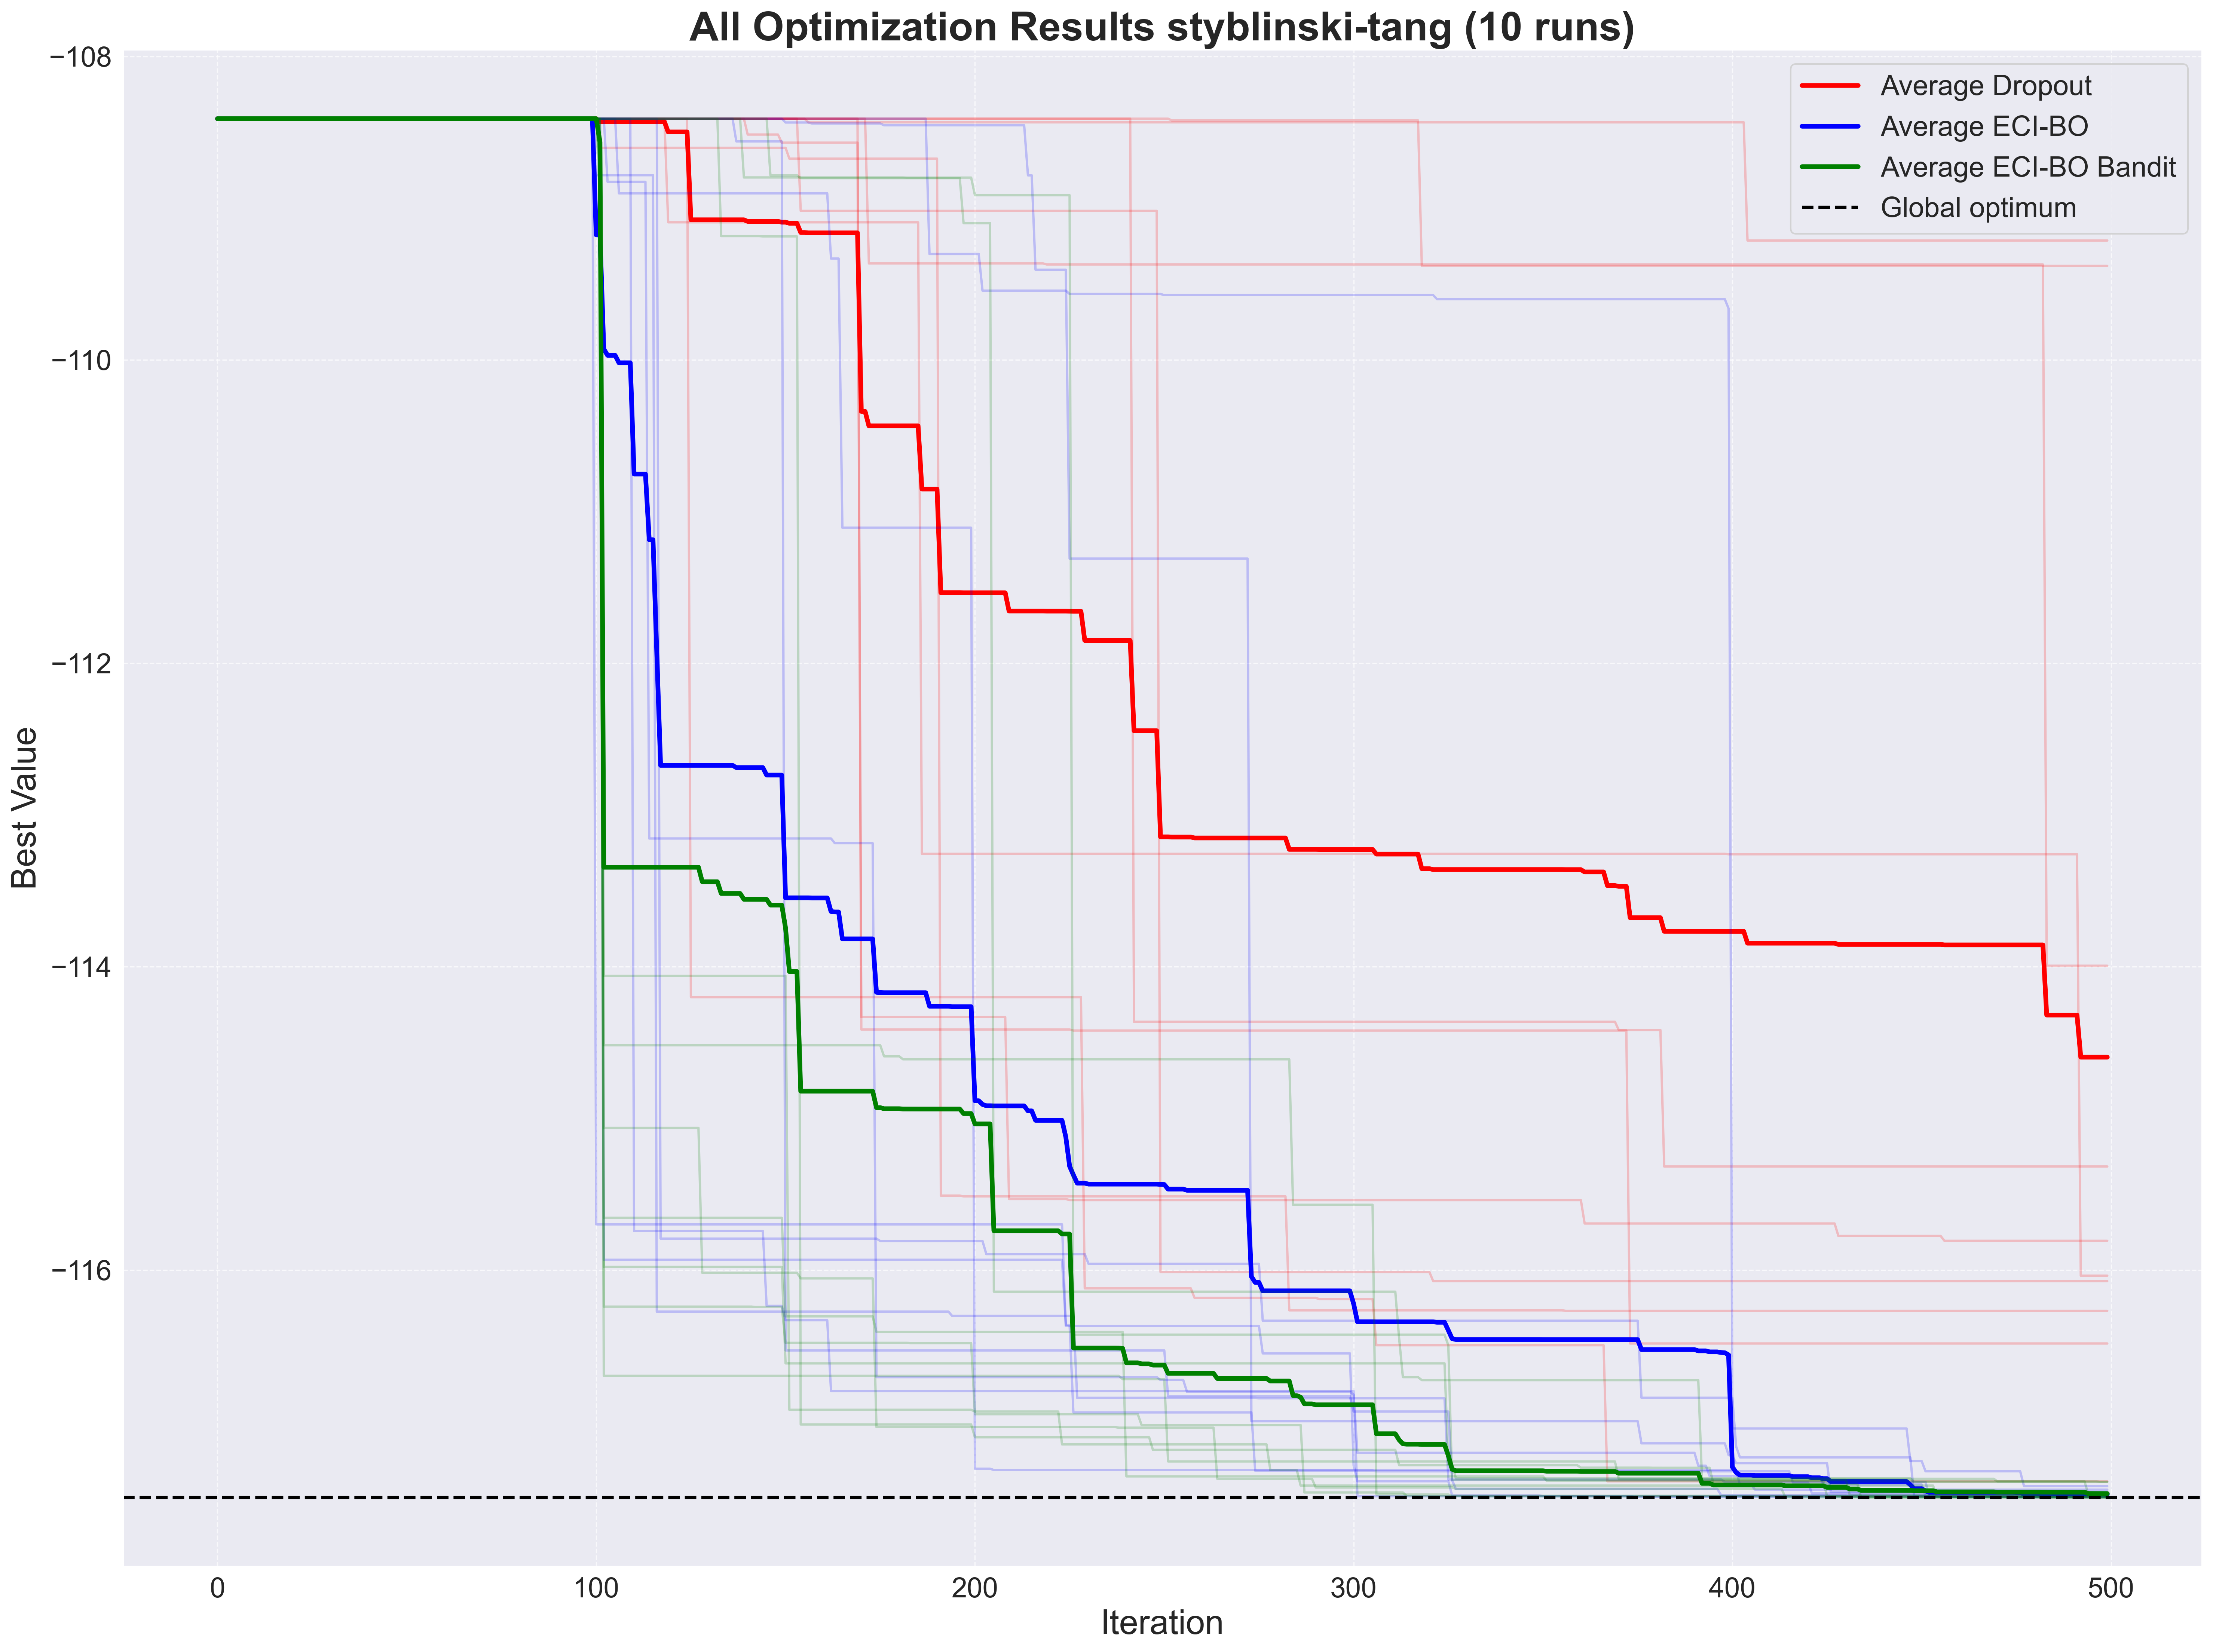

In [100]:
plt.figure(figsize=(20, 15), dpi=300)  # Increased figure size for better visibility

plt.rcParams.update({'font.size': 16})  # Increase the default font size

plt.plot(dropout_bo_copy_average_history, label="Average Dropout", color='red', linewidth=3)
for history in dropout_bo_copy_history:
    plt.plot(history, color='red', alpha=0.2)
plt.plot(eci_bo_history_average, label="Average ECI-BO", color='blue', linewidth=3)
for history in eci_bo_history:
    plt.plot(history, color='blue', alpha=0.2)
plt.plot(eci_bo_bandit_history_average, label="Average ECI-BO Bandit", color='green', linewidth=3)
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.2)
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=2)

plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Best Value", fontsize=22)
plt.title(f"All Optimization Results styblinski-tang ({n_runs} runs)", fontsize=26, fontweight='bold')
plt.legend(fontsize=18, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()  # Adjust the plot to ensure all labels are visible

# Save the plot as a high-resolution PNG file
plt.savefig('optimization_results_high_res_large_font.png', dpi=300, bbox_inches='tight')

## 次元選択の可視化

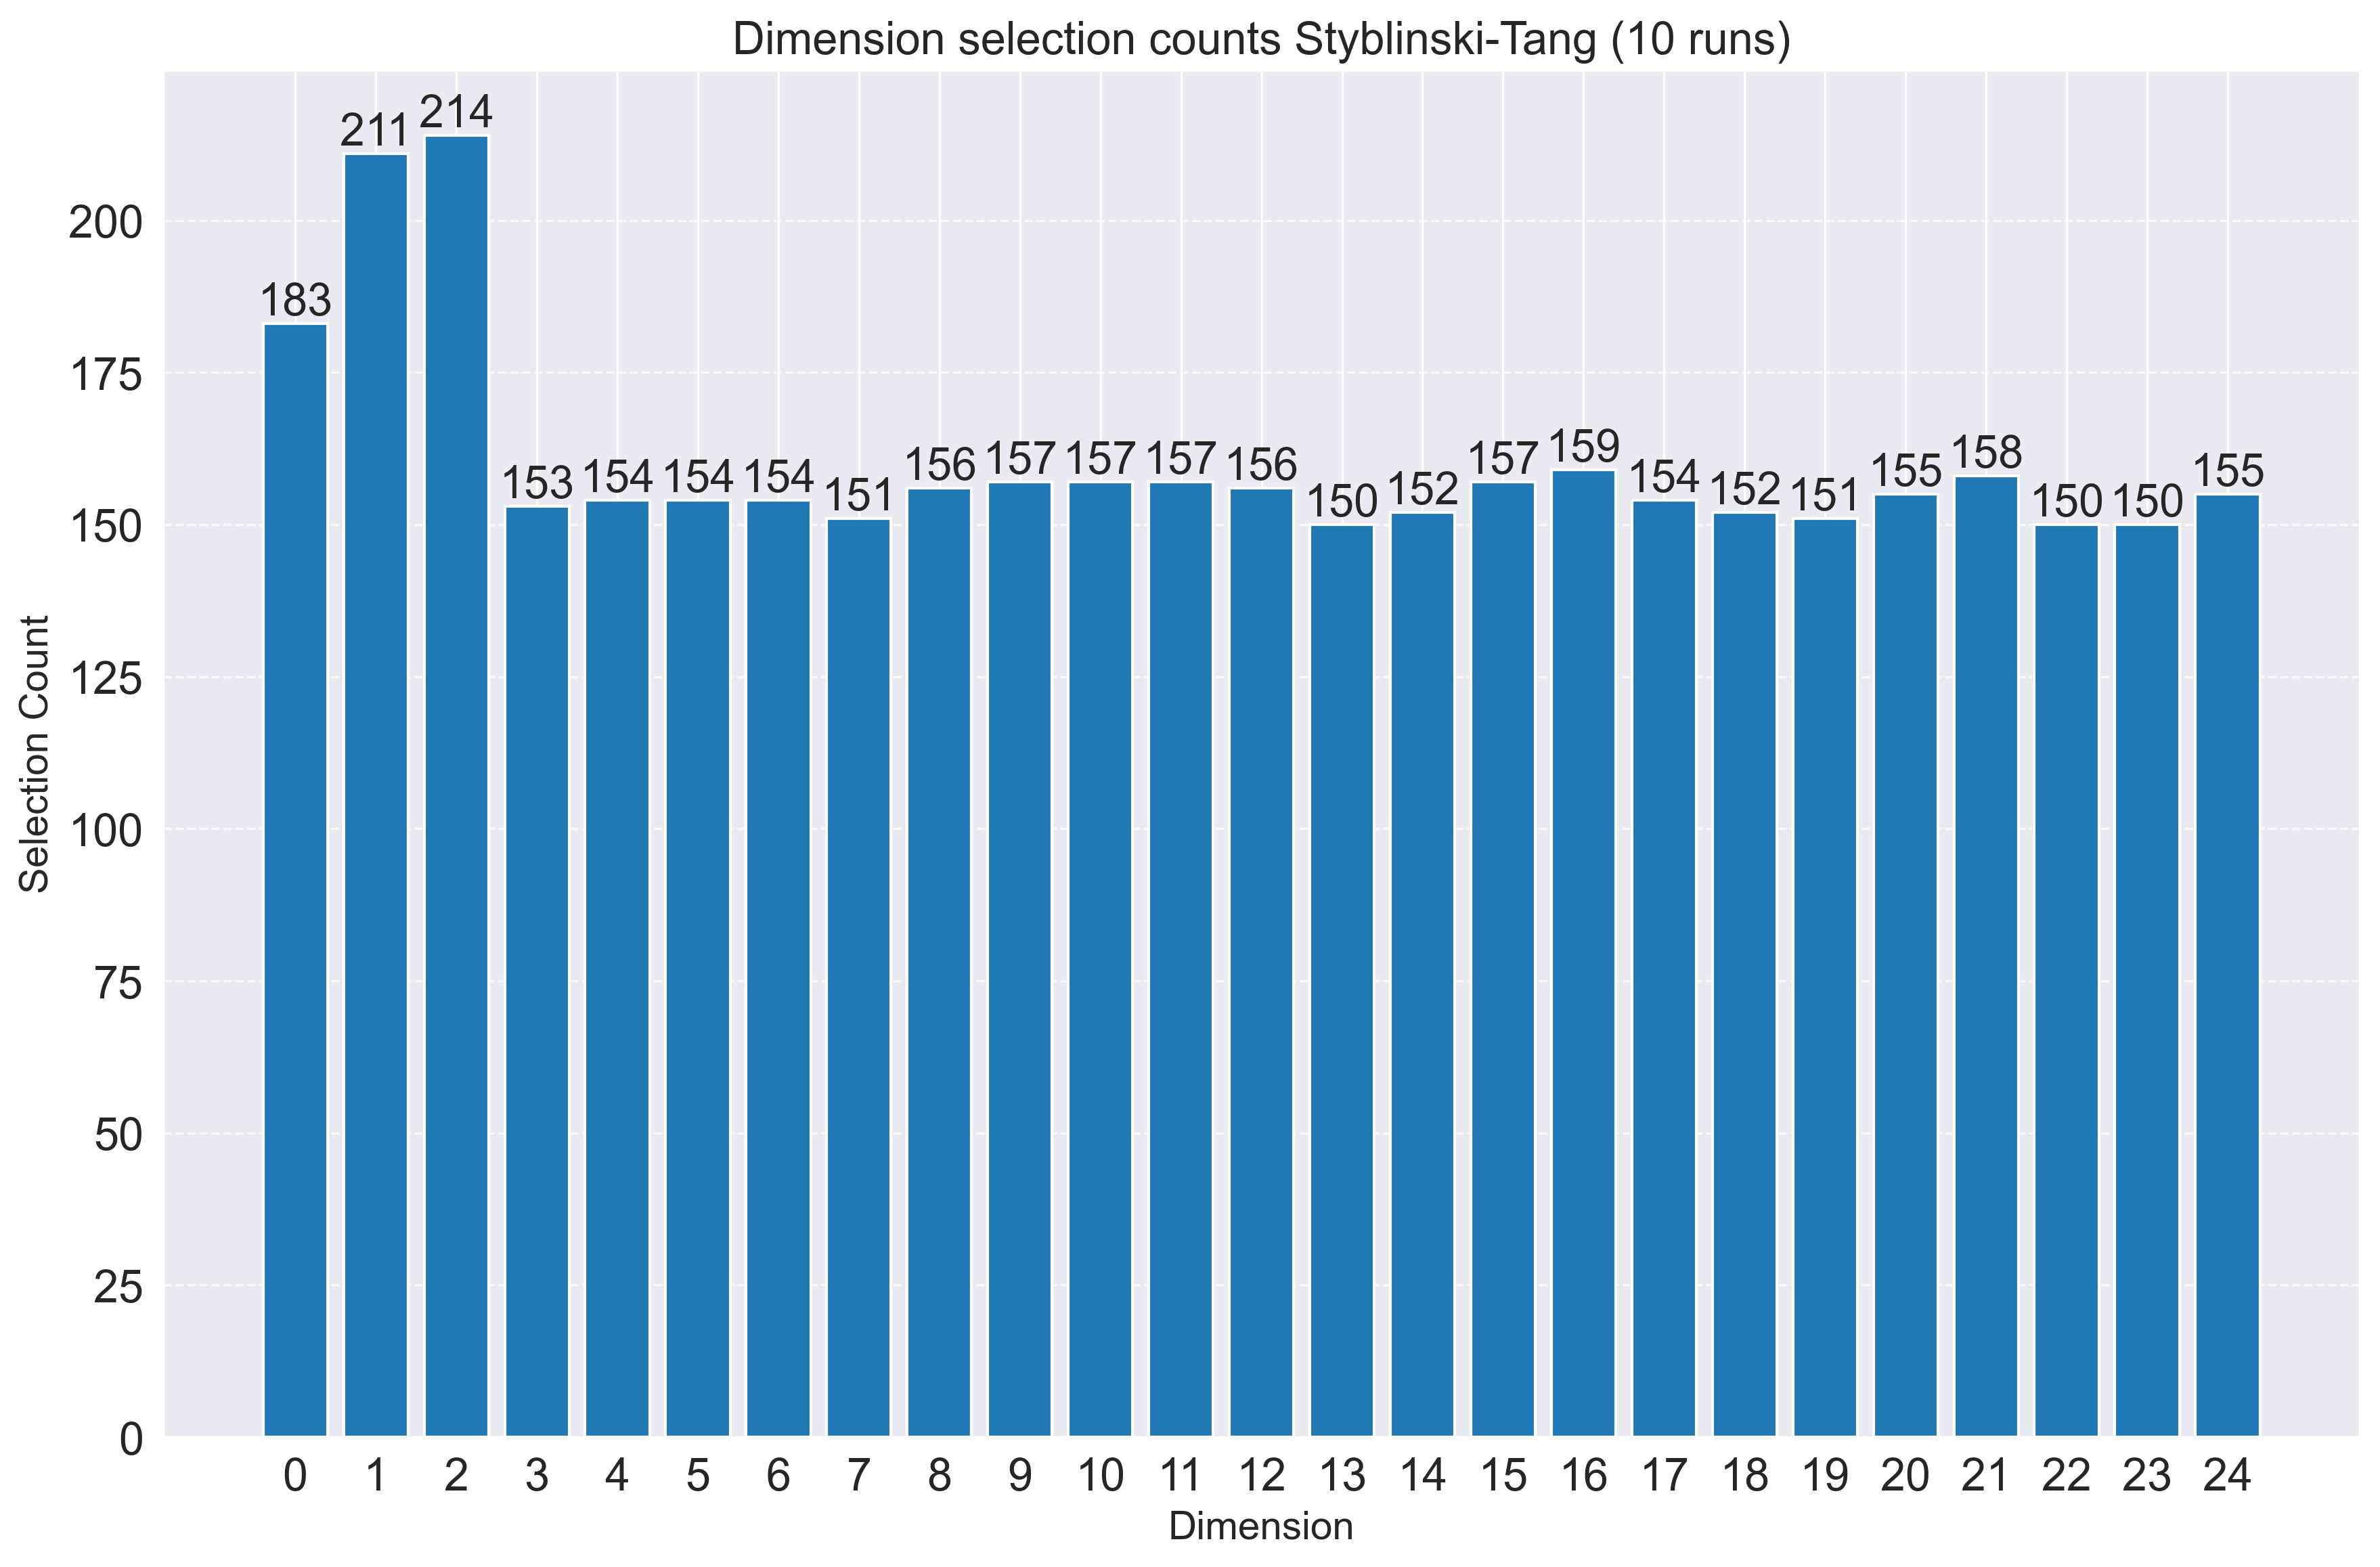

In [108]:
# Flatten the list of lists
flattened_history = [item for sublist in arm_selection_history for item in sublist]

# Count the occurrences of each dimension
dimension_counts = Counter(flattened_history)

# Create lists for x-axis (dimensions) and y-axis (counts)
dimensions = list(range(dim))  # Assuming 'dim' is the total number of dimensions
counts = [dimension_counts.get(d, 0) for d in dimensions]

# Create the histogram
plt.figure(figsize=(12, 8), dpi=300)
plt.bar(dimensions, counts)
plt.xlabel("Dimension", fontsize=14)
plt.ylabel("Selection Count", fontsize=14)
plt.title(f"Dimension selection counts Styblinski-Tang ({n_runs} runs)", fontsize=16)
plt.xticks(dimensions)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# rastrigin関数

In [102]:
def rastrigin(x):
    indices = [0, 1, 2]
    x_selected = x[..., indices]
    return 10 * x_selected.shape[-1] + torch.sum(x_selected ** 2 - 10 * torch.cos(2 * np.pi * x_selected), dim=-1)

# rastrigin関数の最適解
global_optimum = 0.0

# 最適化

In [103]:
dropout_bo_copy_history = []
eci_bo_history = []
eci_bo_bandit_history = []
arm_selection_history = []

In [104]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      for run in range(n_runs):
          dropout_bo_copy = DropoutMixBO(X, dim, active_dim, bounds, n_initial, n_iter, rastrigin, dropout_prob=0.0)
          best_x, best_f = dropout_bo_copy.optimize()
          dropout_bo_copy_history.append(dropout_bo_copy.eval_history)
          pbar.update(33 / n_runs)
      dropout_bo_copy_average_history = np.mean(dropout_bo_copy_history, axis=0)
      for run in range(n_runs):
        eci_bo = ECI_BO(X, rastrigin, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo.optimize()
        eci_bo_history.append(eci_bo.eval_history)
        pbar.update(33 / n_runs)  
      eci_bo_history_average = np.mean(eci_bo_history, axis=0)
      for run in range(n_runs):
        eci_bo_bandit = ECI_BO_Bandit(X, rastrigin, bounds, n_initial, n_iter, dim)
        best_x, best_f = eci_bo_bandit.optimize()
        eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
        arm_selection_history.append(eci_bo_bandit.arm_selection_history)  
        pbar.update(34 / n_runs) 
      eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)  
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

## 結果の保存

In [105]:
def save_or_append_csv(filename, new_data):
    if os.path.exists(filename):
        # ファイルが存在する場合、既存のデータを読み込む
        existing_data = pd.read_csv(filename)
        # 新しいデータを追加
        updated_data = pd.concat([existing_data, new_data], ignore_index=True)
    else:
        # ファイルが存在しない場合、新しいデータをそのまま使用
        updated_data = new_data
    
    # 更新されたデータを保存
    updated_data.to_csv(filename, index=False)

# ディレクトリを作成（存在しない場合）
output_dir = "optimization_rast_results"
os.makedirs(output_dir, exist_ok=True)

# DropoutMixBOの結果を保存または追加
dropout_df = pd.DataFrame(dropout_bo_copy_history)
save_or_append_csv(os.path.join(output_dir, "dropout_mixbo_rast_history.csv"), dropout_df)

# ECI-BOの結果を保存または追加
ecibo_df = pd.DataFrame(eci_bo_history)
save_or_append_csv(os.path.join(output_dir, "eci_bo_rast_history.csv"), ecibo_df)

# ECI-BO Banditの結果を保存または追加
ecibo_bandit_df = pd.DataFrame(eci_bo_bandit_history)
save_or_append_csv(os.path.join(output_dir, "eci_bo_bandit_rast_history.csv"), ecibo_bandit_df)

# 平均履歴も保存または追加
avg_df = pd.DataFrame({
    "DropoutMixBO": [dropout_bo_copy_average_history],
    "ECI-BO": [eci_bo_history_average],
    "ECI-BO Bandit": [eci_bo_bandit_history_average]
})
save_or_append_csv(os.path.join(output_dir, "average_rast_histories.csv"), avg_df)

print(f"Evaluation histories have been saved or appended in the '{output_dir}' directory.")

Evaluation histories have been saved or appended in the 'optimization_rast_results' directory.


## 結果の可視化

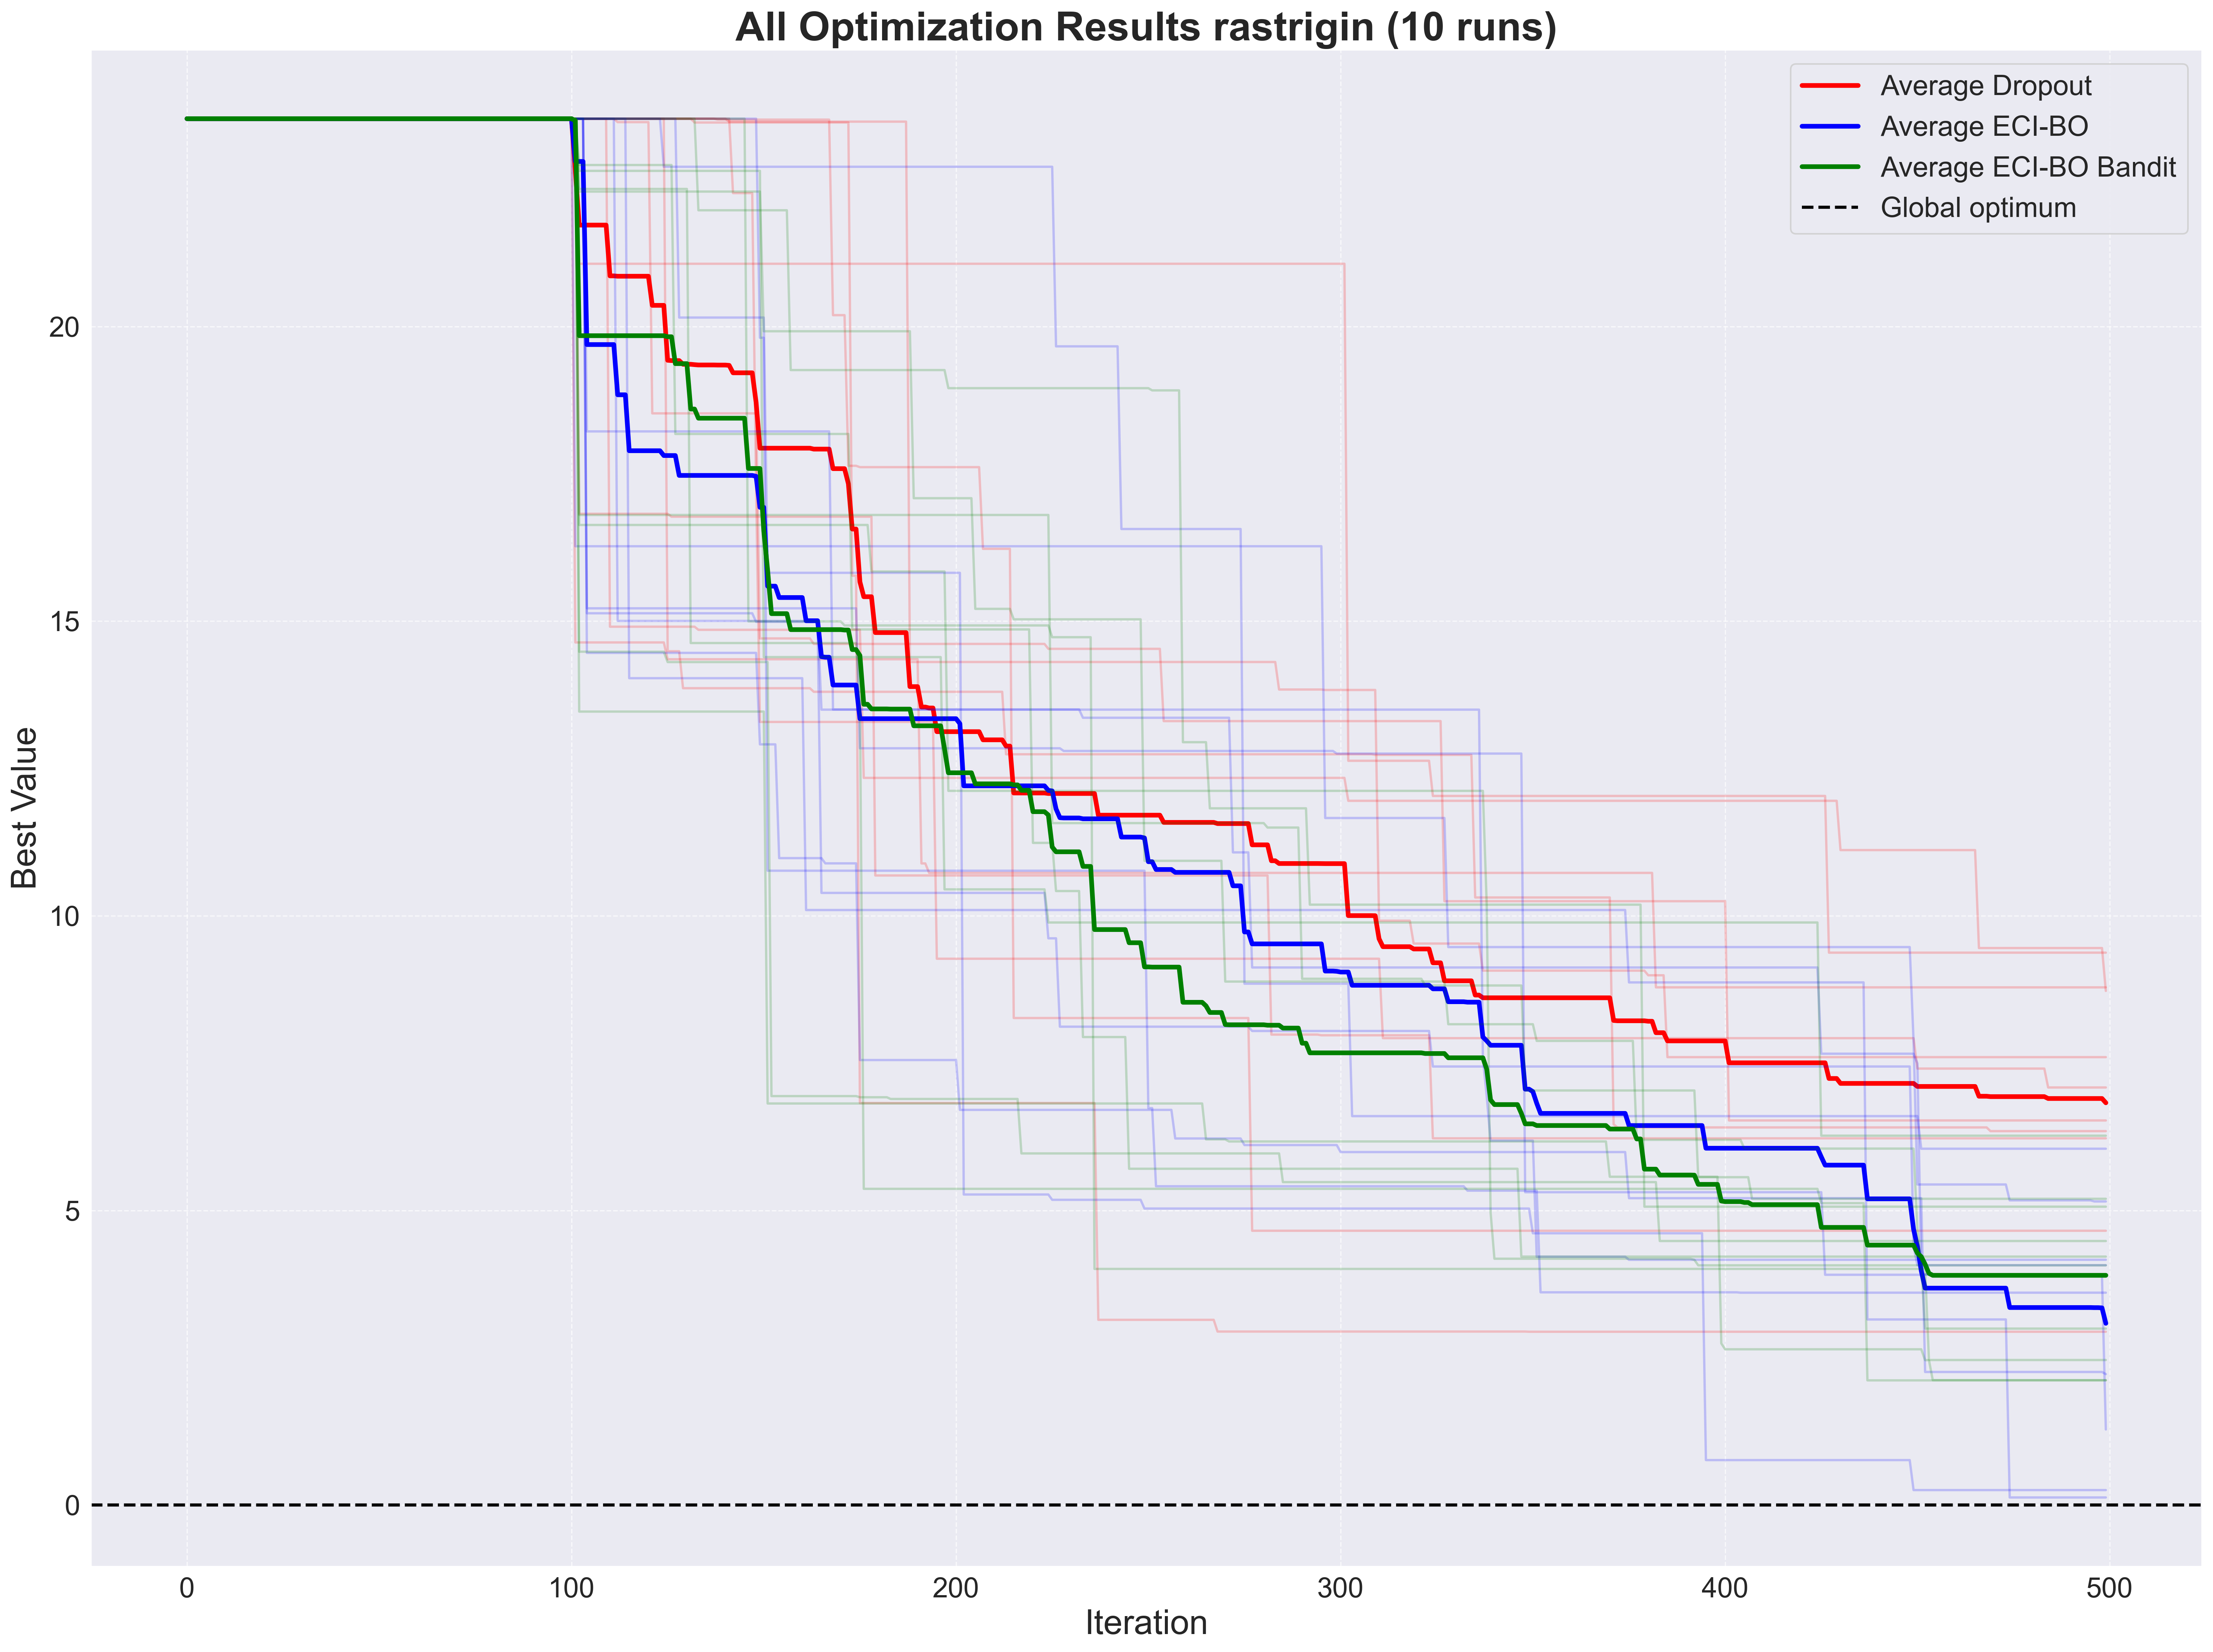

In [106]:
plt.figure(figsize=(20, 15), dpi=300)  # Increased figure size for better visibility

plt.rcParams.update({'font.size': 16})  # Increase the default font size

plt.plot(dropout_bo_copy_average_history, label="Average Dropout", color='red', linewidth=3)
for history in dropout_bo_copy_history:
    plt.plot(history, color='red', alpha=0.2)
plt.plot(eci_bo_history_average, label="Average ECI-BO", color='blue', linewidth=3)
for history in eci_bo_history:
    plt.plot(history, color='blue', alpha=0.2)
plt.plot(eci_bo_bandit_history_average, label="Average ECI-BO Bandit", color='green', linewidth=3)
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.2)
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=2)

plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Best Value", fontsize=22)
plt.title(f"All Optimization Results rastrigin ({n_runs} runs)", fontsize=26, fontweight='bold')
plt.legend(fontsize=18, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()  # Adjust the plot to ensure all labels are visible

# Save the plot as a high-resolution PNG file
plt.savefig('optimization_results_high_res_large_font.png', dpi=300, bbox_inches='tight')

## 次元選択の可視化

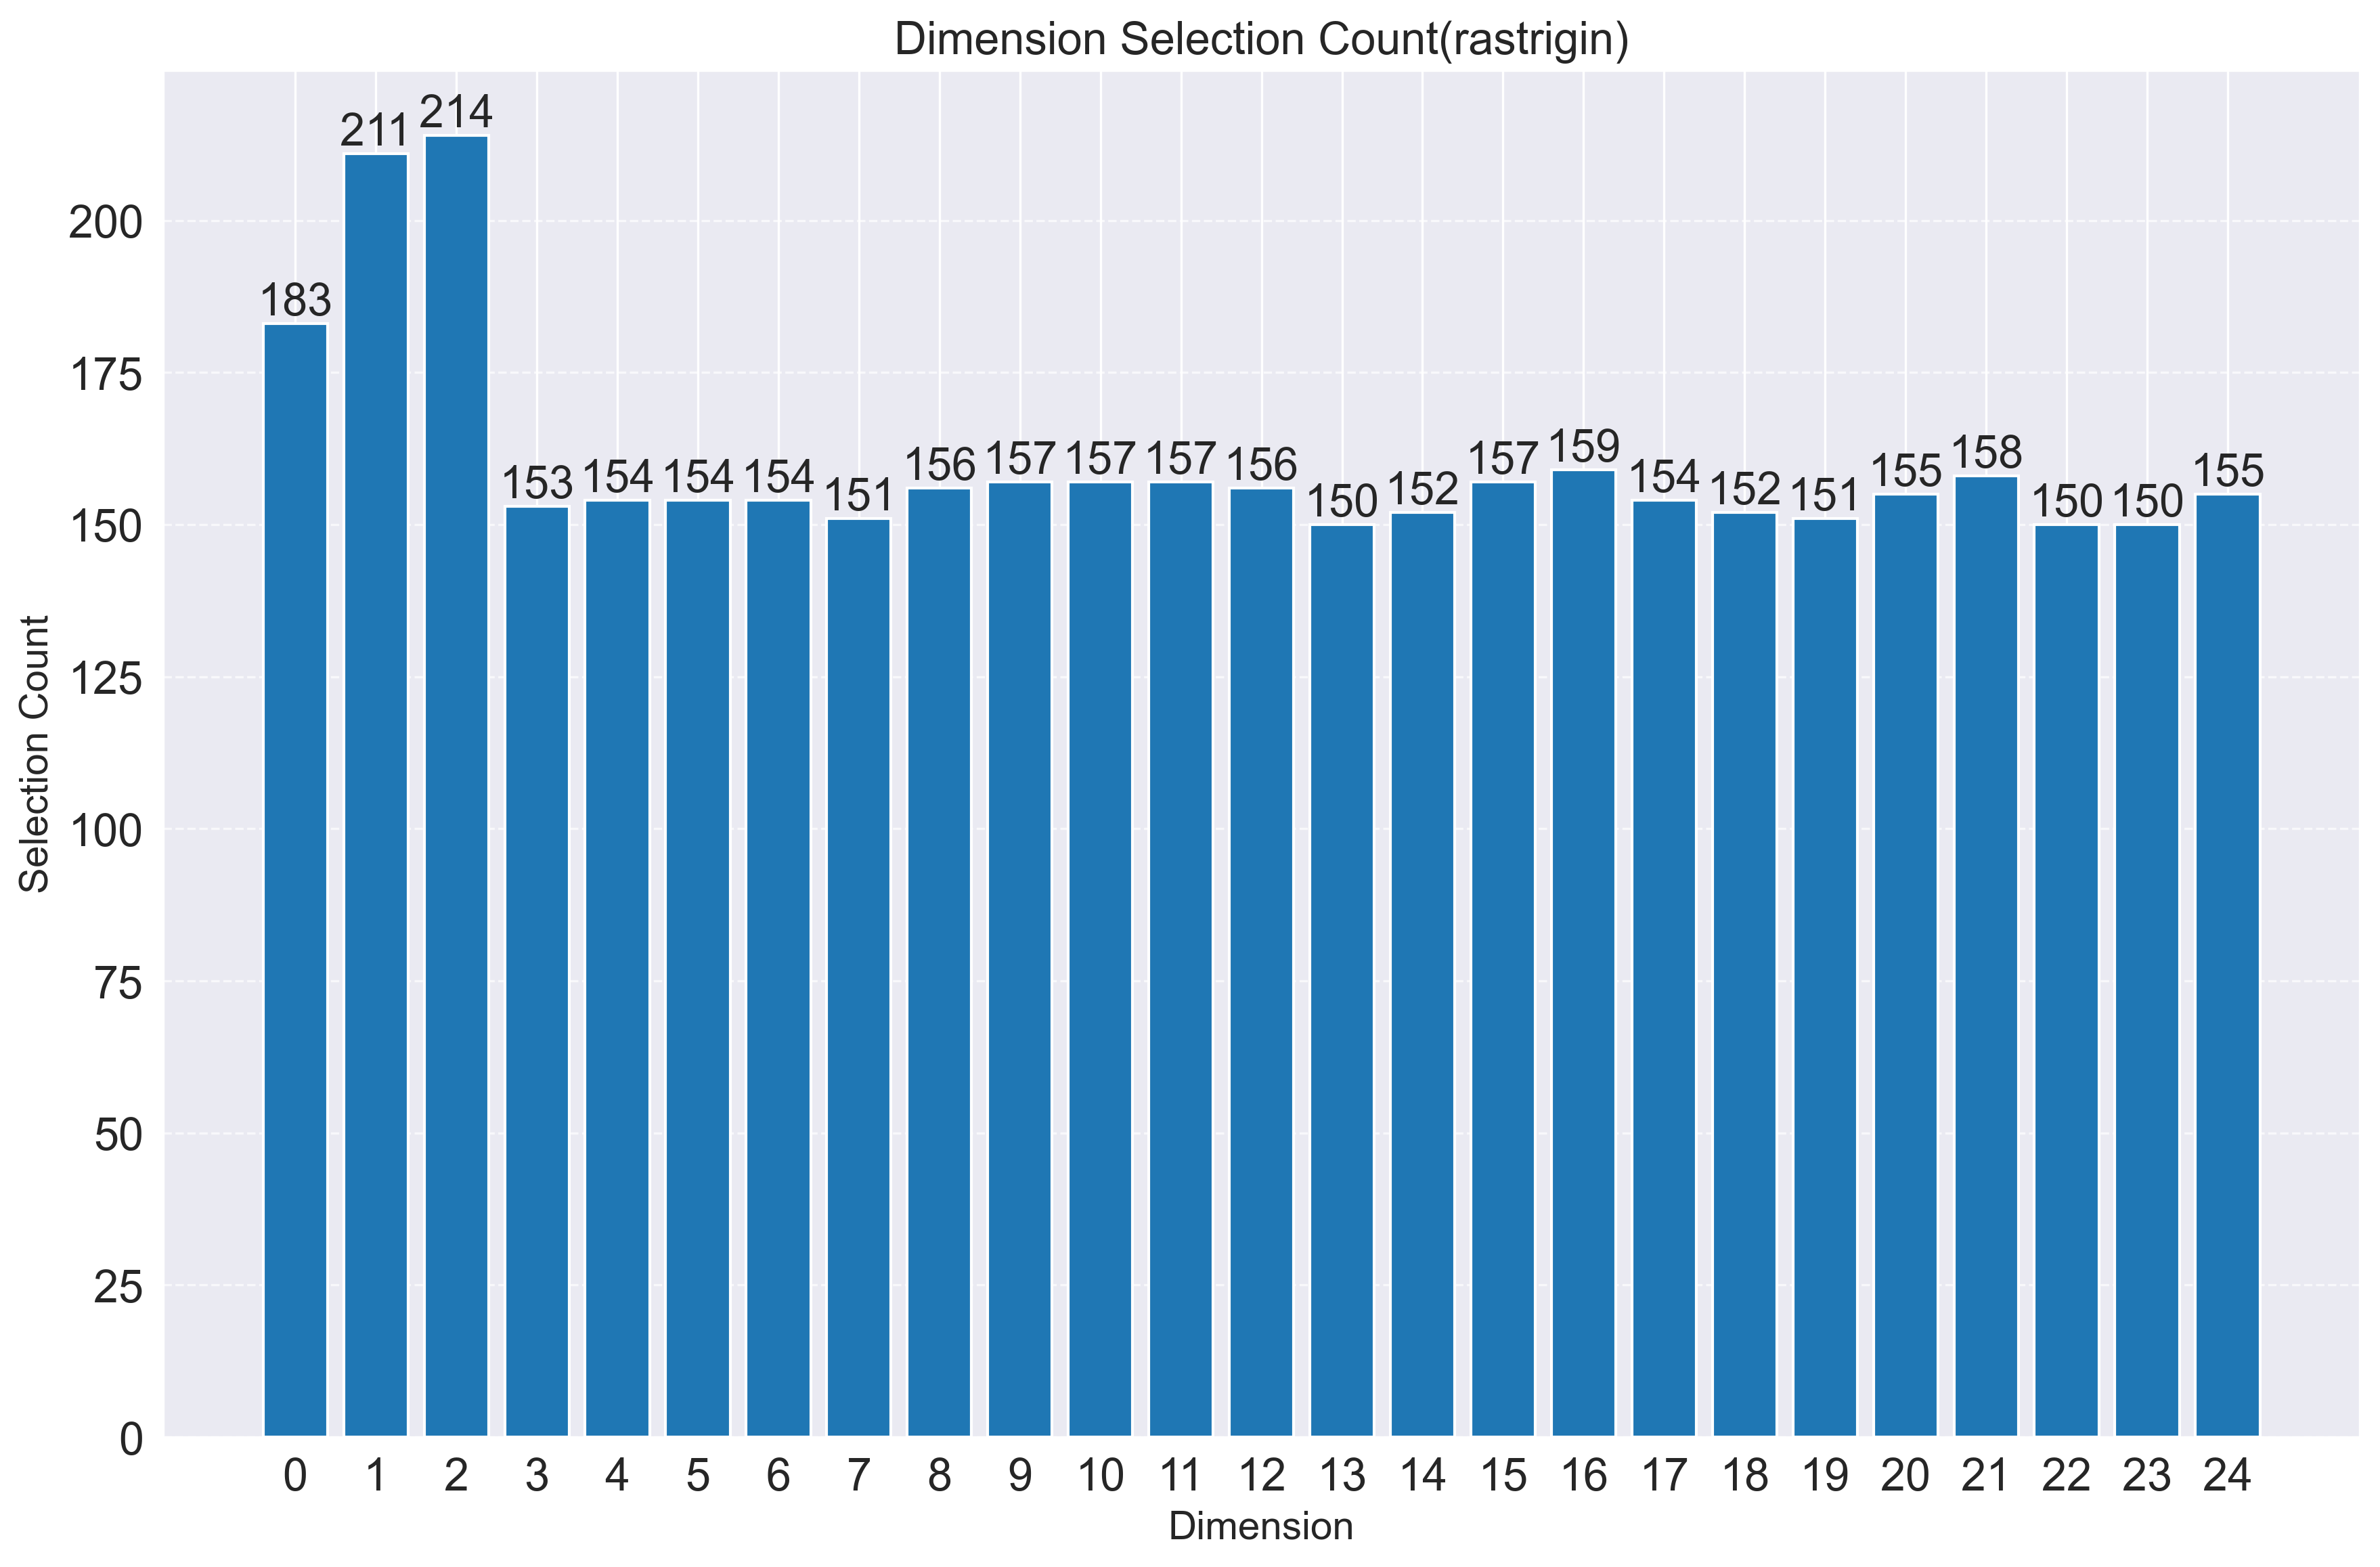

In [107]:
# Flatten the list of lists
flattened_history = [item for sublist in arm_selection_history for item in sublist]

# Count the occurrences of each dimension
dimension_counts = Counter(flattened_history)

# Create lists for x-axis (dimensions) and y-axis (counts)
dimensions = list(range(dim))  # Assuming 'dim' is the total number of dimensions
counts = [dimension_counts.get(d, 0) for d in dimensions]

# Create the histogram
plt.figure(figsize=(12, 8), dpi=300)
plt.bar(dimensions, counts)
plt.xlabel("Dimension", fontsize=14)
plt.ylabel("Selection Count", fontsize=14)
plt.title("Dimension Selection Count(rastrigin)", fontsize=16)
plt.xticks(dimensions)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()